In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tqdm
from math import sqrt
import seaborn as sns;
# sns.set()

In [41]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

In [2]:
file = open('./data/shashlik_61_pulses.txt', 'r')
data = file.readlines()
data = np.array([list(map(float, experiment.split())) for experiment in data])
y = data[:, 0]
y_baseline = data[:, 1]
X = data[:, 2:]

In [3]:
print("Number of samples:", X.shape[0])
print("Dimension of each sample:", X.shape[1])

Number of samples: 7848
Dimension of each sample: 1024


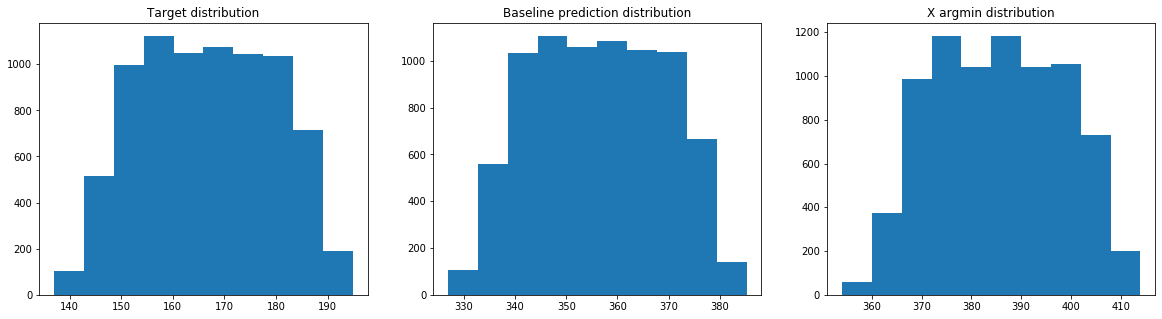

In [4]:
f, axarr = plt.subplots(1, 3, figsize=(20,5))
axarr[0].set_title("Target distribution")
axarr[0].hist(y)

axarr[1].set_title("Baseline prediction distribution")
axarr[1].hist(y_baseline)

axarr[2].set_title("X argmin distribution")
axarr[2].hist(np.argmin(X, axis=1))
plt.show()

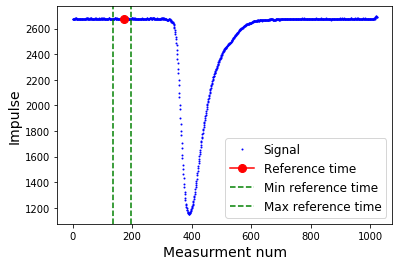

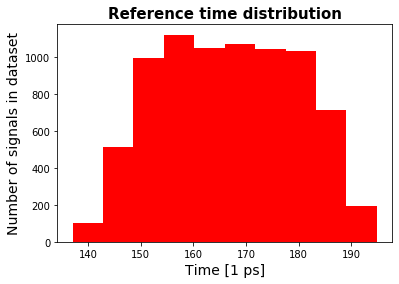

In [5]:
LABEL_FONTSIZE = 14
plt.plot(X[2], 'ro', color='b', markersize=1)
# plt.axvline(x=y[0], color='r')
plt.plot([int(y[2])], [X[2][int(y[2])]], color='r', marker='o', markersize=8)
# plt.show()
plt.axvline(x=np.min(y), color='g', linestyle='--')
plt.axvline(x=np.max(y), color='g', linestyle='--')
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.xlabel('Measurment num', fontsize=LABEL_FONTSIZE)
plt.legend(['Signal', 'Reference time', 'Min reference time', 'Max reference time'], prop={'size': 12})
plt.show()
plt.title("Reference time distribution", weight='bold', fontsize=15)
plt.hist(y, color='r')
plt.xlabel("Time [1 ps]", fontsize=LABEL_FONTSIZE)
plt.ylabel("Number of signals in dataset", fontsize=LABEL_FONTSIZE)
plt.show()

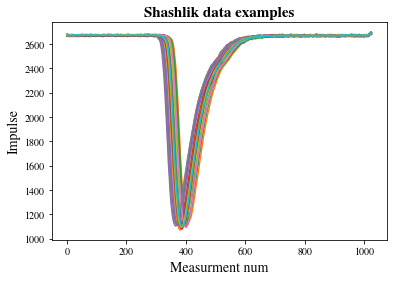

In [45]:
plt.title("Shashlik data examples", fontsize=TITLE_FONTSIZE, weight='bold')
plt.xlabel("Measurment num", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
for i in range(30):
    plt.plot(X[i])
plt.show()

In [6]:
len(X)

7848

In [7]:
import sys
sys.path.insert(0, '../problem2/')

from common import get_data, get_freq_data

In [8]:
X_one_signal, y_one_signal = get_data(is_one_signal=True, data_path='./data/shashlik_61_pulses.txt')

In [9]:
type(X_one_signal)

numpy.ndarray

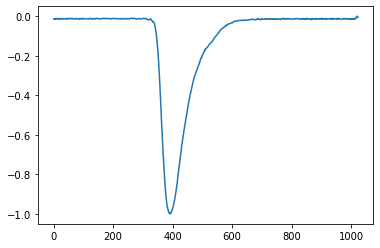

In [10]:
plt.plot(X_one_signal[2])
plt.show()

In [11]:
type(X_one_signal[0])

numpy.ndarray

### ----------------------------------

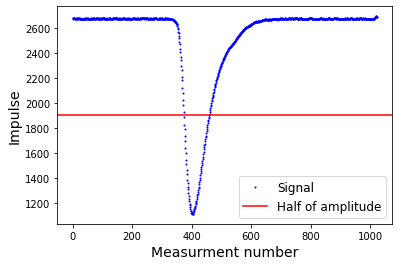

In [12]:
plt.plot(X[0], 'ro', color='b', markersize=1)
plt.axhline(y = np.min(X[0]) + (np.max(X[0] - np.min(X[0])))/2, color='r')
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.legend(['Signal', 'Half of amplitude'], prop={'size': 12})
plt.show()

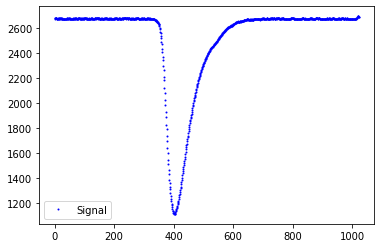

In [13]:
plt.plot(X[0], 'ro', color='b', markersize=1)
plt.legend(['Signal'])
plt.show()

In [14]:
amplitude_half = np.min(X[0]) + (np.max(X[0] - np.min(X[0])))/2
print("Amplitude half")

Amplitude half


In [15]:
res = []
for i in range(len(X)):
    prev = X[i][0]
    for j in range(1, len(X[i])):
        cur = X[i][j]
        if prev > amplitude_half and cur <= amplitude_half:
            break
        prev = cur
    res.append(j)

In [16]:
res = np.array(res).astype("float64")
res -= np.mean(res)

In [17]:
TIME_SCALE_COEF = 0.2

In [18]:
prev = X[0][0]
for i in range(1, len(X[i])):
    cur = X[0][i]
    if prev > amplitude_half and cur <= amplitude_half:
        break
    prev = cur

In [19]:
import random

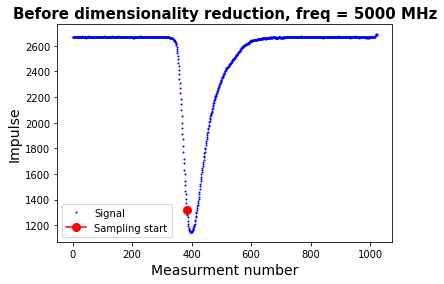

In [20]:
ORIGIN_FREQ = 5000
i = random.choice(range(len(X)))
freq=10

plt.title("Before dimensionality reduction, freq = %d MHz" %ORIGIN_FREQ, weight='bold', fontsize=15)
mean_argmin = int(np.mean(np.argmin(X, axis=1)))
plt.plot(X[i], 'ro', color='b', markersize=1)
plt.plot([mean_argmin], [X[i][int(mean_argmin)]], color='r', marker='o', markersize=8)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)

plt.legend(['Signal', 'Sampling start'])
plt.show()

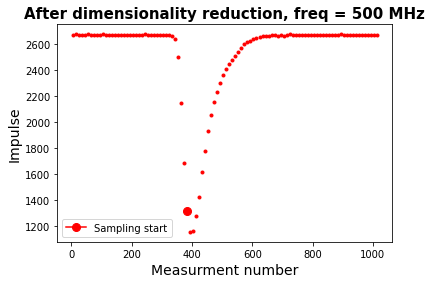

In [21]:
plt.title("After dimensionality reduction, freq = %d MHz" %(ORIGIN_FREQ/freq), weight='bold', fontsize=15)
plt.plot([mean_argmin], [X[i][int(mean_argmin)]], color='r', marker='o', markersize=8)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.legend(['Sampling start'])

for pos in range(mean_argmin, 0, -freq):
    plt.plot([pos], X[i][pos], color='r', marker='o', markersize=3)
    
for pos in range(mean_argmin, len(X[i]), freq):
    plt.plot([pos], X[i][pos], color='r', marker='o', markersize=3)

### ----------------------------------

### Normalize y

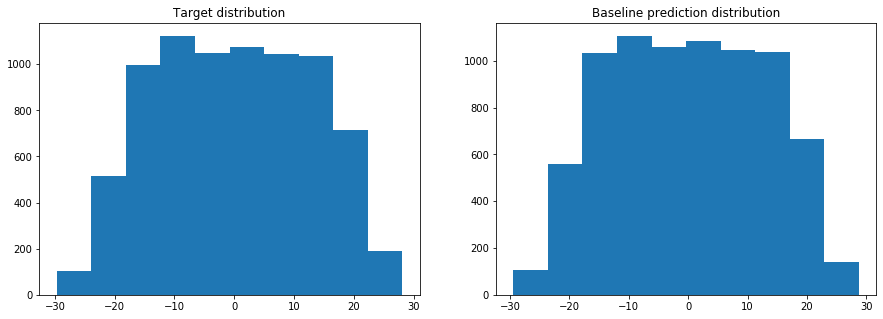

In [22]:
y = y - np.mean(y)
y_baseline = y_baseline - np.mean(y_baseline)

f, axarr = plt.subplots(1, 2, figsize=(15,5))
axarr[0].set_title("Target distribution")
axarr[0].hist(y)

axarr[1].set_title("Baseline prediction distribution")
axarr[1].hist(y_baseline)
plt.show()

### Model

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.preprocessing import PolynomialFeatures

In [24]:
TIME_SCALE_COEF = 0.2

def print_model_scores(X, y, model=LinearRegression()):
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(model, X, y, scoring=scoring, cv=5)
    
    print("95% confidence interval:")
    print("r2_score: %0.5f (+/- %0.5f)" % (scores['test_r2'].mean(), scores['test_r2'].std() * 2))
    print("MSE[ns^2]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_squared_error'].std() * 2))
    print("RMSE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * np.sqrt(-scores['test_neg_mean_squared_error']).mean(), np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).std() * 2))
    print("MAE[ns]: %0.5f (+/- %0.5f)" % (TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean(), TIME_SCALE_COEF*scores['test_neg_mean_absolute_error'].std() * 2))

#### Linear regression metrics

In [25]:
print_model_scores(X, y)

95% confidence interval:
r2_score: 0.99904 (+/- 0.00008)
MSE[ns^2]: 0.00628 (+/- 0.00295)
RMSE[ns]: 0.07921 (+/- 0.00375)
MAE[ns]: 0.06126 (+/- 0.00299)


#### Baseline metrics

In [26]:
print("Baseline metric:")
print("r2_score:", np.round(r2_score(y, y_baseline), decimals=5))
print("MSE[ns^2]:", np.round(TIME_SCALE_COEF**2 * mean_squared_error(y, y_baseline), decimals=5))
print("RMSE[ns]:", np.round(TIME_SCALE_COEF * sqrt(mean_squared_error(y, y_baseline)), decimals=5))
print("MAE[ns]:", np.round(TIME_SCALE_COEF * mean_absolute_error(y, y_baseline), decimals=5))

Baseline metric:
r2_score: 0.99945
MSE[ns^2]: 0.00359
RMSE[ns]: 0.05991
MAE[ns]: 0.04699


### Let's plot errors distribution

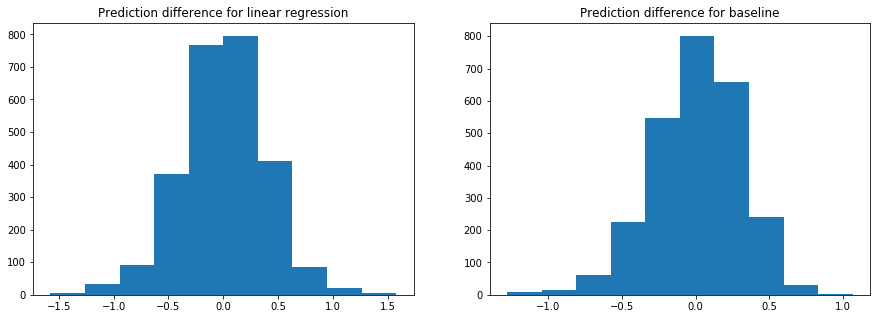

In [27]:
X_train, X_test, y_train, y_test, y_baseline_train, y_baseline_test =\
                        train_test_split(X, y, y_baseline, test_size=0.33, random_state=42)

reg = LinearRegression().fit(X_train, y_train)
predicted = reg.predict(X_test)
regression_diff = predicted - y_test

baseline_diff = y_baseline_test - y_test


f, axarr = plt.subplots(1, 2, figsize=(15,5))
axarr[0].set_title("Prediction difference for linear regression")
axarr[0].hist(regression_diff)

axarr[1].set_title("Prediction difference for baseline")
axarr[1].hist(baseline_diff)
plt.show()

### Experiments with signal frequency

In [28]:
def get_freq_data(X, freq=1, start_point=355):
    X_freq = np.concatenate([X[:, start_point::-freq][:, ::-1], X[:, start_point + freq::freq]], axis=1)
    return X_freq

(array([  60.,  372.,  985., 1183., 1040., 1182., 1042., 1053.,  730.,
         201.]),
 array([354., 360., 366., 372., 378., 384., 390., 396., 402., 408., 414.]),
 <a list of 10 Patch objects>)

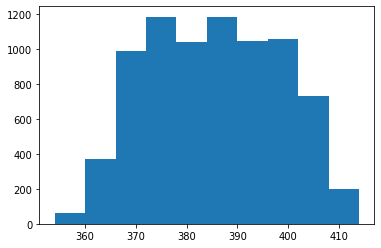

In [29]:
plt.hist(np.argmin(X, axis=1))

In [30]:
TIME_SCALE_COEF = 0.2
ORIGIN_FREQ = 5000
TOP_SPACE = 0.93
freq_values = range(1, 102)
TITLE_FONTSIZE = 15
LABEL_FONTSIZE

def plot_errors(X, y, model, frequency_values, start_point=355, xtick_freq=10):
    r2_scores = []
    mse_scores = []
    mae_scores = []
    rmse_scores = []
    for freq in tqdm.tqdm(frequency_values):
        X_freq = get_freq_data(X, freq=freq, start_point=start_point)

        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X_freq, y, scoring=scoring, cv=5)

        r2_scores.append(scores['test_r2'].mean())
        mse_scores.append(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error'].mean())
        mae_scores.append(TIME_SCALE_COEF * -scores['test_neg_mean_absolute_error'].mean())
        rmse_scores.append(np.sqrt(TIME_SCALE_COEF**2 * -scores['test_neg_mean_squared_error']).mean())
        
        
    f, axarr = plt.subplots(2, 2, figsize=(15,15))
    st = f.suptitle(type(model).__name__, fontsize=20, weight='bold')
#     st.set_y(0.95)
    f.subplots_adjust(top=TOP_SPACE)
    
    xticks = [i for i in range(0, len(frequency_values), xtick_freq)]
    xticklabels = [int(ORIGIN_FREQ/frequency_values[i])\
                                                for i in ([0] + list(range(9, len(frequency_values), xtick_freq)))]
    plt.setp(axarr, xticks=xticks, xticklabels=xticklabels)
    
    axarr[0, 0].set_title("R2 score", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[0, 0].set_ylabel("R2 score", fontsize=LABEL_FONTSIZE)
    axarr[0, 0].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[0, 0].plot(frequency_values, r2_scores)
   
    axarr[0, 1].set_title("MSE", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[0, 1].set_ylabel("MSE [ns^2]", fontsize=LABEL_FONTSIZE)
    axarr[0, 1].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[0, 1].plot(frequency_values, np.array(mse_scores), color='orchid')
    
    axarr[1, 0].set_title("RMSE", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[1, 0].set_ylabel("RMSE [ns]", fontsize=LABEL_FONTSIZE)
    axarr[1, 0].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[1, 0].plot(frequency_values, np.array(rmse_scores), color='green')
                  
    axarr[1, 1].set_title("MAE", fontsize=TITLE_FONTSIZE, weight='bold')
    axarr[1, 1].set_ylabel("MAE [ns]", fontsize=LABEL_FONTSIZE)
    axarr[1, 1].set_xlabel("Sampling frequency [MHz]", fontsize=LABEL_FONTSIZE)
    axarr[1, 1].plot(frequency_values, np.array(mae_scores), color='orange')
    plt.show()


100%|██████████| 101/101 [12:35<00:00,  7.48s/it]


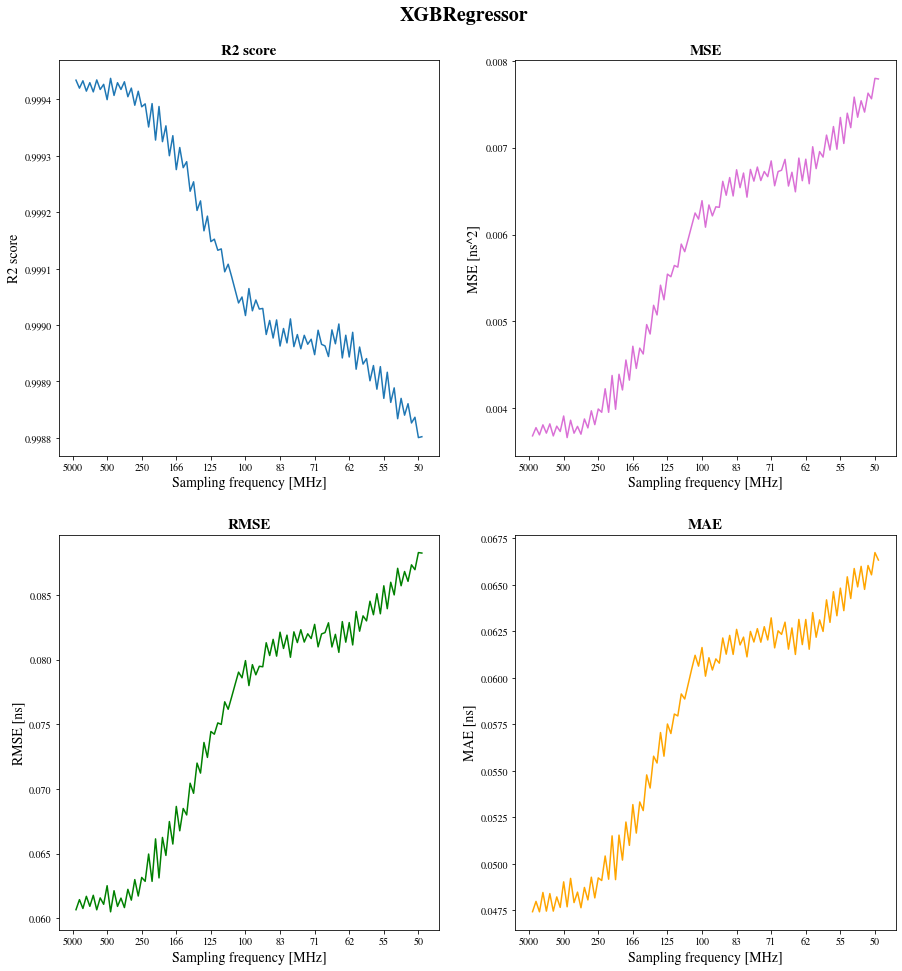

In [46]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objective="reg:linear", random_state=42, verbosity=0)
plot_errors(X, y, xgb_reg, freq_values)

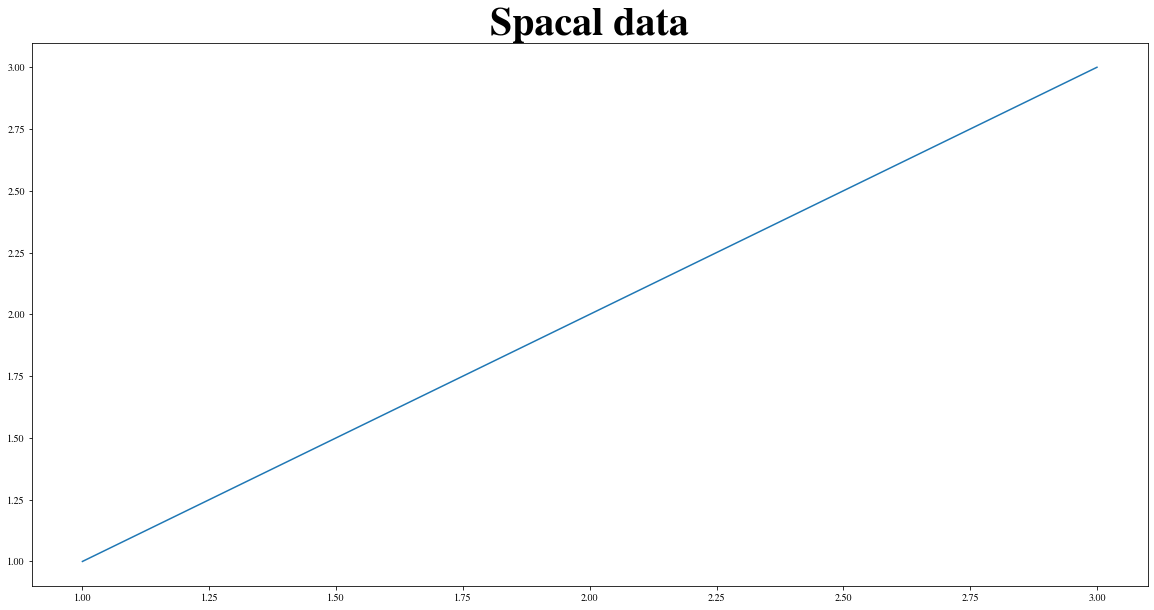

In [54]:
f, _ = plt.subplots(figsize=(20, 10))
plt.plot([1, 2, 3], [1, 2, 3])
plt.title("Spacal data", fontsize=40, weight='bold')
plt.show()

100%|██████████| 101/101 [00:23<00:00,  4.31it/s]


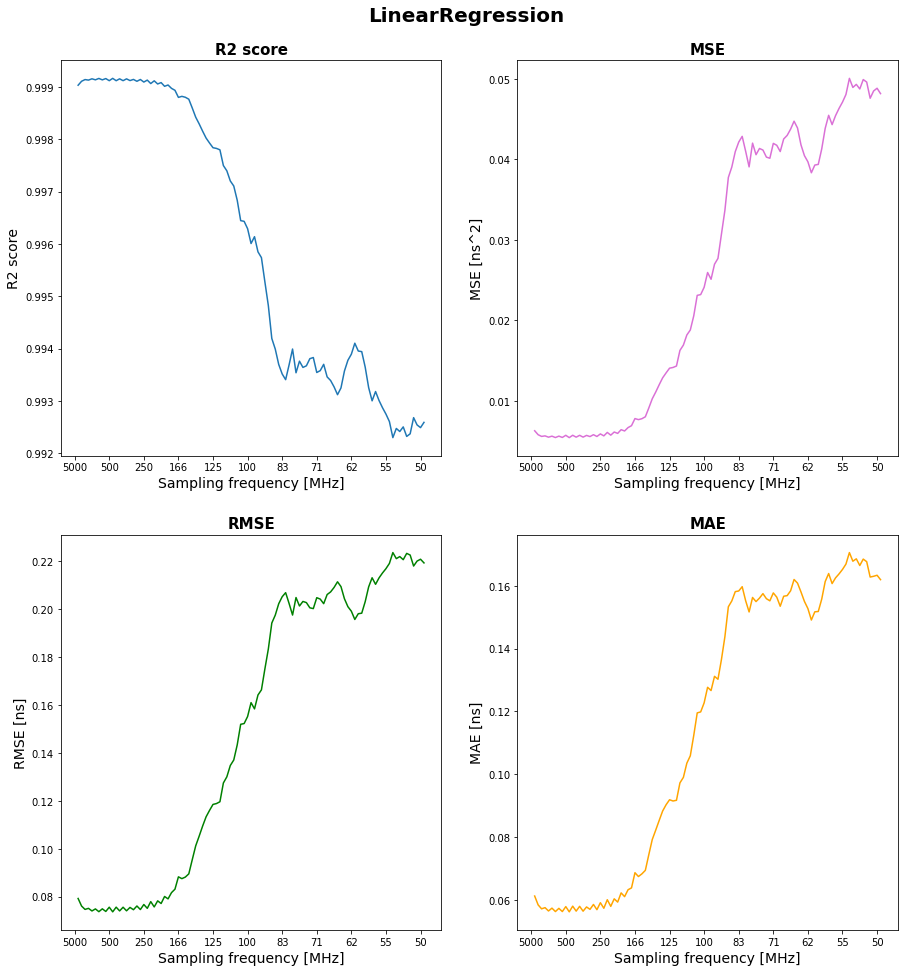

In [32]:
reg = LinearRegression()
plot_errors(X, y, reg, freq_values)

100%|██████████| 101/101 [03:44<00:00,  2.22s/it]


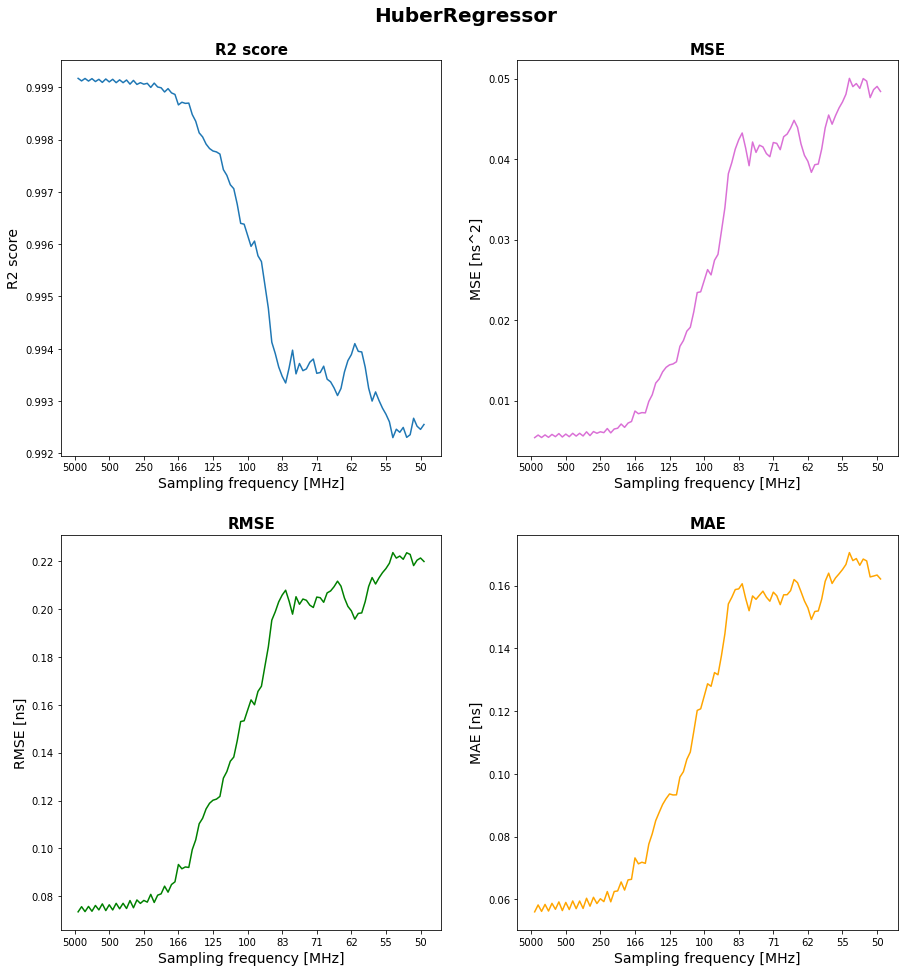

In [33]:
from sklearn.linear_model import HuberRegressor

huber_reg = HuberRegressor(epsilon= 5.09, alpha= 0.0004)
plot_errors(X, y, huber_reg, freq_values)

#### As we may see, if we take freq = 20, we significantly reduce the size of our data and have the same errors rate

## Let's try to beat baseline score

##### First approach - polynomial features

In [34]:
freq = 15
start_point = 355
X_freq = get_freq_data(X, freq=freq, start_point=start_point)

print("Shape after reducing sampling frequency", X_freq.shape)

Shape after reducing sampling frequency (7848, 68)


In [35]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)
X_polynomial = poly.fit_transform(X_freq)

print("Shape after adding polynomial features", X_polynomial.shape)

Shape after adding polynomial features (7848, 2415)


In [36]:
print("Polynomial linear regression metrics:")
print_model_scores(X_polynomial, y)

Polynomial linear regression metrics:
95% confidence interval:
r2_score: 0.99956 (+/- 0.00004)
MSE[ns^2]: 0.00285 (+/- 0.00062)
RMSE[ns]: 0.05337 (+/- 0.00116)
MAE[ns]: 0.04194 (+/- 0.00075)


In [37]:
print("Baseline score:")
print("r2_score:", r2_score(y, y_baseline))
print("MSE[ns^2]:", TIME_SCALE_COEF**2 * mean_squared_error(y, y_baseline))
print("RMSE[ns]:", TIME_SCALE_COEF * sqrt(mean_squared_error(y, y_baseline)))
print("MAE[ns]:", TIME_SCALE_COEF * mean_absolute_error(y, y_baseline))

Baseline score:
r2_score: 0.9994485733281531
MSE[ns^2]: 0.0035896503112183265
RMSE[ns]: 0.05991369051576047
MAE[ns]: 0.04699444102187255


###### Linear regression provides a worse result than the baseline solution, but we can beat the baseline solution by adding polynomial features

### Second approach - data preprocessing

#### Without dimensionality reduction

In [38]:
X_scaled = np.array([experiment - np.max(experiment) for experiment in X])
X_scaled = np.array([experiment/-np.min(experiment) for experiment in X_scaled])

In [39]:
plt.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

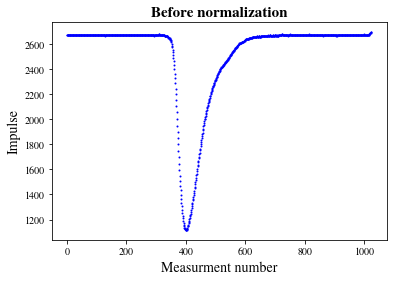

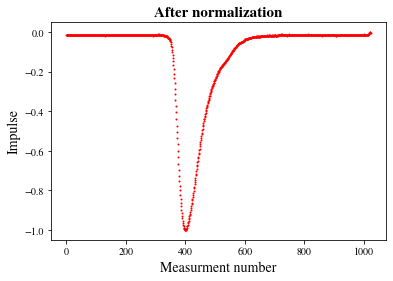

In [40]:
i = random.choice(range(len(X)))

plt.title("Before normalization", weight='bold', fontsize=15)
plt.plot(X[i], 'ro', color='b', markersize=1)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.show()

plt.title("After normalization", weight='bold', fontsize=15)
plt.plot(X_scaled[i], 'ro', color='r', markersize=1)
plt.xlabel("Measurment number", fontsize=LABEL_FONTSIZE)
plt.ylabel("Impulse", fontsize=LABEL_FONTSIZE)
plt.show()

In [28]:
print("Linear regression metrics without dimensionality reduction:")
print_model_scores(X_scaled, y)

Linear regression metrics without dimensionality reduction:
95% confidence interval:
r2_score: 0.99963 (+/- 0.00001)
MSE[ns^2]: 0.00242 (+/- 0.00073)
RMSE[ns]: 0.04921 (+/- 0.00148)
MAE[ns]: 0.03892 (+/- 0.00124)


#### With dimensionality reduction

In [29]:
X_scaled_freq = get_freq_data(X_scaled, freq=freq)

In [30]:
print("Linear regression metrics with dimensionality reduction:")
print_model_scores(X_scaled_freq, y)

Linear regression metrics with dimensionality reduction:
95% confidence interval:
r2_score: 0.99965 (+/- 0.00002)
MSE[ns^2]: 0.00226 (+/- 0.00087)
RMSE[ns]: 0.04749 (+/- 0.00185)
MAE[ns]: 0.03728 (+/- 0.00172)


### Third approach - tuning our models

##### For details take a look at hyperopt.ipynb

In [31]:
import xgboost as xgb

In [32]:
xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.00244, booster='dart', eta= 0.017326, gamma=0.19504, 
                           reg_lambda=0.22451, max_depth=8, verbosity=0)

In [33]:
print("XGB regressor with dimensionality reduction")
print_model_scores(X_freq, y, xgb_reg)

XGB regressor with dimensionality reduction
95% confidence interval:
r2_score: 0.99961 (+/- 0.00004)
MSE[ns^2]: 0.00257 (+/- 0.00091)
RMSE[ns]: 0.05064 (+/- 0.00180)
MAE[ns]: 0.03942 (+/- 0.00082)


### Fourth approach - building ensemble of models

##### For more details take a look at ensemble.ipynb